In [3]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import scipy.linalg
import matplotlib.pyplot as plt
import linear_shrinkage
import Util
from os.path import join
from generating_MTP import generate_mat as generate_MTP2
import os

In [4]:
ret, ret_nonan, univ, tradeidx, dates = Util.load_data()

In [2]:
Ns = [100, 200, 500, 1000]
ratios = [0.25, 0.5, 1, 2, 4]
P = 1

In [ ]:
for N in Ns:
    for r in ratios:
        T = int(r * N)
#         if N == 100 or N == 200 or N == 500: #already done
#             continue
        if T >= 2000:
            continue
            #then the array will contain nans
        print("Working on N = {}, T = {}".format(N, T))
        pastRets = []
        uids = []
        for h in range(len(univ)):
            pastRet = Util.get_past_period(h, T, N, univ, tradeidx, ret)
            pastRets.append(pastRet)
            uids.append(h)
        folder = "kendall_cov_historical_N_{}_T_{}".format(N, T)
        if not os.path.isdir('matlab/data/{}'.format(folder)):
            os.mkdir('matlab/data/{}'.format(folder))
        
        Util.populate_kendall_covs_from_samples(folder, uids, pastRets)
        Util.run_parallel_MTP2(7, folder, uids)
        Util.get_MTP2_OOS(folder, N, P, univ, tradeidx, ret)
        
        Util.run_parallel_LS(7, folder, pastRets, uids)
        Util.get_LS_OOS(folder, N, P, univ, tradeidx, ret)

Working on N = 100, T = 25
Done populating all Kendall covs
Done with running all commands!
Done with running all commands for LS!
Working on N = 100, T = 50
Done populating all Kendall covs
Done with running all commands!
Done with running all commands for LS!
Working on N = 100, T = 100


In [ ]:
#This is for running LS all by itself
'''Ns = [200, 500, 1000]
ratios = [0.25, 0.5, 1, 2, 4]

for N in Ns:
    for r in ratios:
        T = int(r * N)
        if N == 200 and T in [50, 100]: #already done
            continue
        if T > 2000:
            continue
        print("Working on N = {}, T = {}".format(N, T))
        pastRets = []
        uids = []
        for h in range(len(univ)):
            pastRet = Util.get_past_period(h, T, N, univ, tradeidx, ret)
            pastRets.append(pastRet)
            uids.append(h)
        folder = "historical_N_{}_T_{}".format(N, T)
        Util.run_parallel_LS(7, folder, pastRets, uids)
        Util.get_LS_OOS(folder, N, P, univ, tradeidx, ret)'''

In [56]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})

FileNotFoundError: [Errno 2] No such file or directory: 'matlab/data/kendall_cov_historical_N_100_T_100/MTP2_OOS_rets.npy'

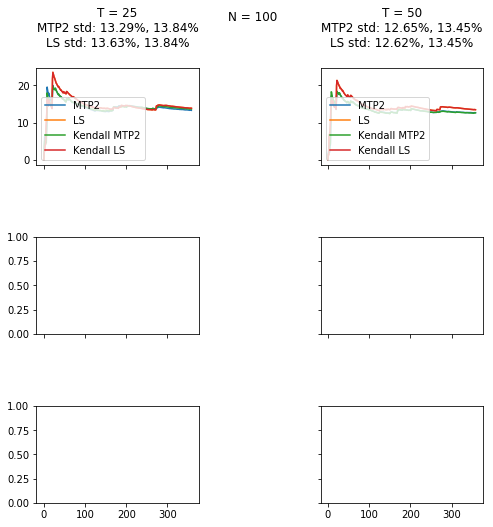

In [11]:
for N in Ns:
    if N >= 1000:
        continue
    if N == 500:
        f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(8,5))
        axes = [ax1, ax2, ax3, ax4]
    else:
        f, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3, 2, sharex='col', sharey='row', figsize=(8,8))
        axes = [ax1, ax2, ax3, ax4, ax5, ax6]
    f.suptitle("N = {}".format(N))
    plt.subplots_adjust(wspace = 0.75, hspace = 0.75)
    for r, ax in zip(ratios, axes):
        T = int(r * N)
        if T >= 2000:
            continue
        folder = "historical_N_{}_T_{}".format(N, T)
        MTP2_rets, LS_rets = Util.load_OOS(folder)
        folder = "kendall_cov_" + folder
        kendall_MTP2_rets, kendall_LS_rets = Util.load_OOS(folder)
        #print("N = {}, T = {}".format(N, T))
        #print("MTP2 var {} vs. LS var {}".format(np.var(MTP2_rets), np.var(LS_rets)))
        #ax.set_xlabel("Number of months evaluated")
        #ax.set_ylabel("variance(returns) for given number of months")
        MTP2_std = 100*np.sqrt(12)*float(np.std(MTP2_rets))
        LS_std = 100*np.sqrt(12)*float(np.std(LS_rets))
        kMTP2_std = 100*np.sqrt(12)*float(np.std(kendall_MTP2_rets))
        kLS_std = 100*np.sqrt(12)*float(np.std(kendall_LS_rets))
        
        ax.set_title("T = {}\nMTP2 std: {:0.2f}%, {:0.2f}%\nLS std: {:0.2f}%, {:0.2f}%\n".format(T, 
                                                                           MTP2_std,
                                                                           LS_std,
                                                                           kMTP2_std,
                                                                           kLS_std))
        
        ax.plot(Util.cumulative_annualized_std(MTP2_rets), label = 'MTP2')
        ax.plot(Util.cumulative_annualized_std(LS_rets), label = 'LS')
        ax.plot(Util.cumulative_annualized_std(kendall_MTP2_rets), label = 'Kendall MTP2')
        ax.plot(Util.cumulative_annualized_std(kendall_LS_rets), label = 'Kendall LS')
        ax.legend()
    f.savefig('./figures/historical_data_N_{}'.format(N))
    plt.show()